In [2]:
import torch
import tensorflow as tf
import scipy as sc
import numpy as np
from PIL import Image
import os
import re
import torch.nn.functional as F
import cv2
import numpy as np
import time
from scipy.io import loadmat, savemat
import torch.nn as nn
from tensorflow.keras.optimizers import Adam
from torch.autograd import Variable
from torchvision.models import resnet
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from resnet import resnet50

import matplotlib.pyplot as plt

In [ ]:
folder_path = os.path.dirname(os.path.dirname(os.getcwd()))
folder_path

In [3]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [4]:
torch.cuda.empty_cache()

In [5]:
transform = transforms.ToTensor()

In [6]:
device = torch.device("cuda:0")
torch.set_default_device(device)

#torch.cuda.set_per_process_memory_fraction(0.5, device=device)

print(torch.cuda.get_device_properties(device).multi_processor_count)
torch.cuda.memory_allocated(device=torch.device("cuda"))
torch.cuda.memory_summary(device=torch.device("cuda"), abbreviated=False)

36


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|---------------------------------------------------------------------------|\n| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |

In [33]:
image = cv2.imread(r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Images_Cropped\Train\001.jpg')
orig_label = cv2.imread(r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Masks_Cropped\Train\001.png')

In [34]:
label=np.copy(orig_label)
orig_label[orig_label == 2] = 255
orig_label[orig_label == 1] = 128
#label = label[:,:,0]
label[label == 2] = 1
label[label == 1] = 255

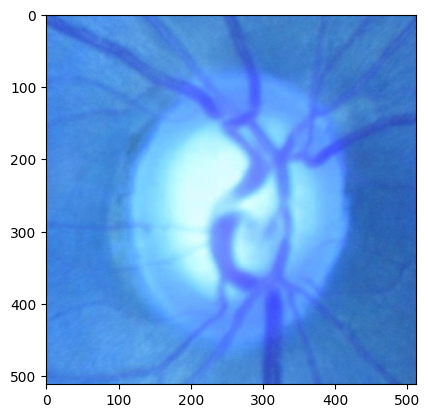

In [35]:
plt.imshow(image)

In [36]:
print(label.shape)

(512, 512, 3)


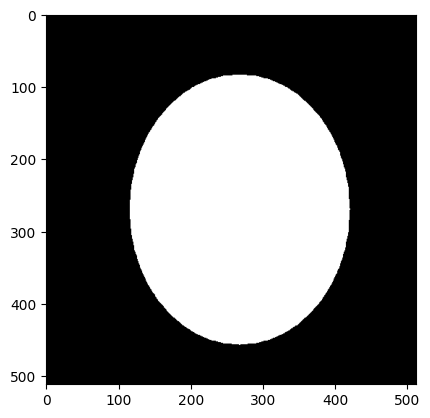

In [37]:
plt.imshow(label)

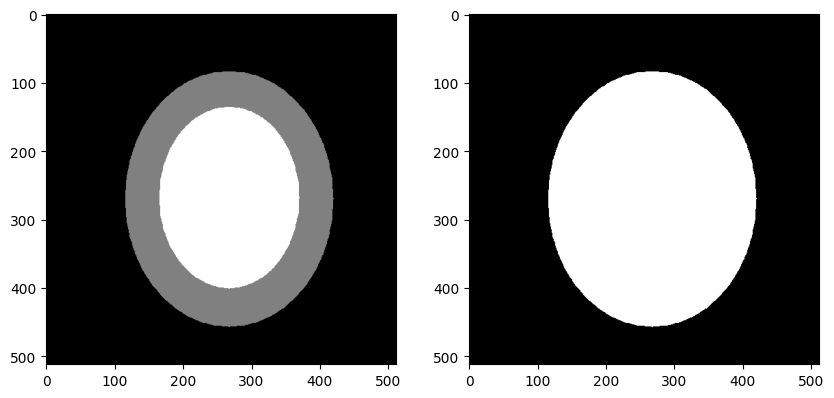

In [47]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)  #2,4,1
plt.imshow(orig_label)
plt.subplot(2,2,2)  #2,4,1
plt.imshow(label)  

In [11]:
unique_values, counts = np.unique(label, return_counts=True)
for value, count in zip(unique_values, counts):
    print(str(value) +":    "+str(count))

0:    518433
255:    267999


In [12]:
label.shape

(512, 512, 3)

In [13]:
unique_values, counts = np.unique(label, return_counts=True)
for value, count in zip(unique_values, counts):
    print(str(value) +":    "+str(count))

0:    518433
255:    267999


In [14]:
class CustomSegmentationDataset(Dataset):
    def __init__(self, image_paths, label_paths, transform=None):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transform = transform
    
    def __len__(self):
        return len(os.listdir(self.image_paths))
        
    def __getitem__(self, idx):
        image_path = os.listdir(self.image_paths)[idx]
        label_path = os.listdir(self.label_paths)[idx]
        
        image = cv2.imread(self.image_paths + "\/" + image_path)
        #image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        label = cv2.imread(self.label_paths + "\/" +label_path)
        label = label[:,:,0]
        label[label == 2] = 1
        label[label == 1] = 255

        if self.transform:
            image = Image.fromarray(image) 
            image = self.transform(image)#.to(device)
            #image = image/255

            label = Image.fromarray(label)
            label = self.transform(label)
        
        return image, label

In [15]:
data_transform = transforms.Compose([
    transforms.Resize((256, 256), antialias=True),
    transforms.ToTensor(),
])

In [16]:
train_dataset = CustomSegmentationDataset(r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Images_Cropped\Train', r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Masks_Cropped\Train', data_transform)
valid_dataset = CustomSegmentationDataset(r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Images_Cropped\Valid', r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Masks_Cropped\Valid', data_transform)

In [17]:
batchSize = 64
train_data = torch.utils.data.DataLoader(train_dataset, batch_size=batchSize, shuffle=True, generator=torch.Generator(device='cuda'), num_workers=0, 
    pin_memory=True)
valid_data = torch.utils.data.DataLoader(valid_dataset, batch_size=batchSize, shuffle=True, generator=torch.Generator(device='cuda'), num_workers=0, 
    pin_memory=True)

In [18]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1, padding=0, stride=1, dilation=1, bias=False):
        super(ConvBlock, self).__init__()
        padding = (kernel_size + (kernel_size - 1) * (dilation - 1)) // 2
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, bias=bias),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.convInst = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, bias=bias),
            nn.ReLU()
        )

    def forward(self, x):
        if x.shape[-2] == 1 and x.shape[-1]==1:
             out = self.convInst(x)
        else:
            out = self.conv(x)
        return out
    
    def upsample(input, size=None, scale_factor=None, align_corners=False):
        out = F.interpolate(input, size=size, scale_factor=scale_factor, mode='bilinear', align_corners=align_corners)
        return out


In [19]:
class PyramidPooling(nn.Module):
    def __init__(self, in_channels):
        super(PyramidPooling, self).__init__()
        self.pooling_size = [1, 2, 3, 6]
        self.channels = in_channels // 4

        self.pool1 = nn.Sequential(
            nn.AdaptiveAvgPool2d(self.pooling_size[0]),
            ConvBlock(in_channels, self.channels, kernel_size=1),
        )

        self.pool2 = nn.Sequential(
            nn.AdaptiveAvgPool2d(self.pooling_size[1]),
            ConvBlock(in_channels, self.channels, kernel_size=1),
        )

        self.pool3 = nn.Sequential(
            nn.AdaptiveAvgPool2d(self.pooling_size[2]),
            ConvBlock(in_channels, self.channels, kernel_size=1),
        )

        self.pool4 = nn.Sequential(
            nn.AdaptiveAvgPool2d(self.pooling_size[3]),
            ConvBlock(in_channels, self.channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        out1 = self.pool1(x)
        out1 = upsample(out1, size=x.size()[-2:])

        out2 = self.pool2(x)
        out2 = upsample(out2, size=x.size()[-2:])

        out3 = self.pool3(x)
        out3 = upsample(out3, size=x.size()[-2:])

        out4 = self.pool4(x)
        out4 = upsample(out4, size=x.size()[-2:])

        out = torch.cat([x, out1, out2, out3, out4], dim=1)

        return out


In [20]:
def upsample(input, size=None, scale_factor=None, align_corners=False):
    out = F.interpolate(input, size=size, scale_factor=scale_factor, mode='bilinear', align_corners=align_corners)
    return out

In [21]:
# class PSPNet(nn.Module):
#     def __init__(self, n_classes=64, n_out_classes=1):
#         super(PSPNet, self).__init__()
#         self.out_channels = 2048

#         self.backbone = resnet50(pretrained=True)
#         self.stem = nn.Sequential(
#             *list(self.backbone.children())[:4],
#         )
#         self.block1 = self.backbone.layer1
#         self.block2 = self.backbone.layer2
#         self.block3 = self.backbone.layer3
#         self.block4 = self.backbone.layer4
#         self.low_level_features_conv = ConvBlock(512, 64, kernel_size=3)

#         self.depth = self.out_channels // 4
#         self.pyramid_pooling = PyramidPooling(self.out_channels)
        
#         self.decoder = nn.Sequential(
#             ConvBlock(self.out_channels * 2, self.depth, kernel_size=3),
#             nn.Dropout(0.1),
#             nn.Conv2d(self.depth, n_out_classes, kernel_size=1),
#             #nn.Sigmoid()
#         )

#         self.aux = nn.Sequential(
#             ConvBlock(self.out_channels // 2, self.depth // 2, kernel_size=3),
#             nn.Dropout(0.1),
#             nn.Conv2d(self.depth // 2, n_classes, kernel_size=1),
#         )

#         self.semantic_criterion = nn.CrossEntropyLoss(ignore_index=255, weight=None).cuda()
#         self.auxiliary_criterion = nn.CrossEntropyLoss(ignore_index=255, weight=None).cuda()

#     def forward(self, images, label=None):
#         outs = []
#         for x in images:
#             x = x.unsqueeze(0)
#             # x = images[key]
#             out = self.stem(x)
#             out1 = self.block1(out)
#             out2 = self.block2(out1)
#             out3 = self.block3(out2)
#             aux_out = self.aux(out3)
#             #aux_out = self.backbone.fc(out)
#             aux_out = upsample(aux_out, size=x.shape[-2:], align_corners=True)
#             out4 = self.block4(out3)
            
#             out = self.pyramid_pooling(out4)
#             out = self.decoder(out)
#             out = upsample(out, size=x.size()[-2:])

#             out = upsample(out, size=x.shape[-2:], align_corners=True)
#             outs.append(out)
#         #out = torch.stack(outs, dim=-1).mean(dim=-1)
#         out = torch.stack(outs, dim=1).mean(dim=0)
#         out = nn.Sigmoid(o)
#         return out

In [22]:
class PSPNet(nn.Module):
    def __init__(self, n_classes=64, n_out_classes=1):
        super(PSPNet, self).__init__()
        self.out_channels = 2048

        self.backbone = resnet50(pretrained=True)
        self.stem = nn.Sequential(
            *list(self.backbone.children())[:4],
        )
        self.block1 = self.backbone.layer1
        self.block2 = self.backbone.layer2
        self.block3 = self.backbone.layer3
        self.block4 = self.backbone.layer4
        self.low_level_features_conv = ConvBlock(512, 64, kernel_size=3)

        self.depth = self.out_channels // 4
        self.pyramid_pooling = PyramidPooling(self.out_channels)
        
        self.decoder = nn.Sequential(
            ConvBlock(self.out_channels * 2, self.depth, kernel_size=3),
            nn.Dropout(0.1),
            nn.Conv2d(self.depth, n_out_classes, kernel_size=1),
            nn.Sigmoid()
        )

        self.aux = nn.Sequential(
            ConvBlock(self.out_channels // 2, self.depth // 2, kernel_size=3),
            nn.Dropout(0.1),
            nn.Conv2d(self.depth // 2, n_classes, kernel_size=1),
        )

        self.semantic_criterion = nn.CrossEntropyLoss(ignore_index=255, weight=None).cuda()
        self.auxiliary_criterion = nn.CrossEntropyLoss(ignore_index=255, weight=None).cuda()
        self.sigm = nn.Sigmoid()
        self.sftmax = nn.Softmax()
    def forward(self, x, label=None):
        out = self.stem(x)
        out1 = self.block1(out)
        out2 = self.block2(out1)
        out3 = self.block3(out2)
        # aux_out = self.aux(out3)
        # #aux_out = self.backbone.fc(out)
        # aux_out = upsample(aux_out, size=x.shape[-2:], align_corners=True)
        out4 = self.block4(out3)
        
        out = self.pyramid_pooling(out4)
        out = self.decoder(out)
        out = upsample(out, size=x.size()[-2:])

        out = upsample(out, size=x.shape[-2:], align_corners=True)
        # outs.append(out)
        # #out = torch.stack(outs, dim=-1).mean(dim=-1)
        # out = torch.stack(outs, dim=1).mean(dim=0)
        #out = self.sftmax(out)
        return out

In [23]:
num_epochs = 25  #25 epoch good
best_val_loss = float('inf')
early_stop_patience = 3
learning_rate = 0.0001
weight_decay = 0.001

In [24]:
model = PSPNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) 
criterion = torch.nn.BCELoss()
print(model)

Already download
PSPNet(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Seque

In [25]:
# train_loss_list = []
# valid_loss_list = [] 
# total_accuracy = 0.0
# total_iou = 0.0
# total_samples = 0
# success_epoch = 0
# clip_value = 1

# for epoch in range(num_epochs): 
#     start_time = time.time()
#     print(f'Epoch {epoch+1}/{num_epochs}:', end = ' ')
#     success_epoch+=1
#     train_loss = 0
#     valid_loss = 0
#     #Iterating over the training dataset in batches 
#     model.train() 
#     for images, labels in train_data: 
#         #Extracting images and target labels for the batch being iterated 
#         images = images.to(device) 
#         labels= labels.to(device) 
#         #Calculating the model output and the cross entropy loss 
#         outputs = model.forward(images) 
#         loss = criterion(outputs, labels) 
#         optimizer.zero_grad() 
#         loss.backward() 
#         optimizer.step() 
        
#         train_loss += loss.item()
#     train_loss_list.append(train_loss/len(train_data))
#     print(f"Time:{time.time() - start_time} sec   Training loss = {train_loss_list[-1]}")

In [26]:
# zzzzzzzzzzzzzz

In [27]:
train_loss_list = []
valid_loss_list = [] 
total_accuracy = 0.0
total_iou = 0.0
total_samples = 0
success_epoch = 0
clip_value = 1

for epoch in range(num_epochs): 
    start_time = time.time()
    print(f'Epoch {epoch+1}/{num_epochs}:', end = ' ')
    
    success_epoch+=1
    train_loss = 0
    valid_loss = 0
    #Iterating over the training dataset in batches 
    model.train() 
    for images, labels in train_data: 
        #Extracting images and target labels for the batch being iterated 
        images = images.to(device) 
        labels= labels.to(device) 
        #Calculating the model output and the cross entropy loss 
        outputs = model.forward(images) 
        # outputs = (outputs>0.5).float()
        # labels = (labels==1).float()
        # outputs.requires_grad = True
        
        # outputs = tf.where(outputs.cpu().detach().numpy() > 0.5, 1, 0)
        # labels =  tf.where(labels.cpu().detach().numpy() == 1, 1, 0)
        # with device:
        #     outputs = tf.identity(outputs)
        #     labels = tf.identity(labels)
    
        loss = criterion(outputs, labels) 
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step() 
        
        train_loss += loss.item() 
    model.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(valid_data):
            images = images.to(device) 
            labels = labels.to(device)
            
            outputs = model(images) 

            # outputs = (outputs>0.5).float()
            # labels = (labels==1).float()
            # outputs.requires_grad = True
            
            # outputs = tf.where(outputs.cpu().detach().numpy() > 0.5, 1, 0)
            # labels =  tf.where(labels.cpu().detach().numpy() == 1, 1, 0)
            # with device:
            #     outputs = tf.identity(outputs)
            #     labels = tf.identity(labels)
            
            loss = criterion(outputs, labels)
        
            valid_loss += loss.item() 

    
    if valid_loss < best_val_loss:
        best_val_loss = valid_loss
        current_patience = 0
    else:
        current_patience += 1
        if current_patience >= early_stop_patience:
            break
    #Printing loss for each epoch 
    train_loss_list.append(train_loss/len(train_data))
    valid_loss_list.append(valid_loss/len(valid_data)) 
    print(f"Time:{time.time() - start_time} sec   Training loss = {train_loss_list[-1]} Validation loss = {valid_loss_list[-1]}")# IoU_train = {average_iou_train}  Iou_valid = {average_iou_valid} Accuracy_train = {average_accuracy_train} Accuracy_valid = {average_accuracy_valid}") #  DICE: {dice_coef}")      

Epoch 1/25: Time:679.0986516475677 sec   Training loss = 0.25465783290565014 Validation loss = 1.1813207864761353
Epoch 2/25: Time:664.7209243774414 sec   Training loss = 0.10470331739634275 Validation loss = 0.4388466775417328
Epoch 3/25: Time:667.266767501831 sec   Training loss = 0.08434451837092638 Validation loss = 0.24881421029567719
Epoch 4/25: Time:660.7190155982971 sec   Training loss = 0.07233295030891895 Validation loss = 0.12339228764176369
Epoch 5/25: Time:662.8111381530762 sec   Training loss = 0.06417040200904012 Validation loss = 0.09477343410253525
Epoch 6/25: Time:663.1290347576141 sec   Training loss = 0.05827888986095786 Validation loss = 0.08237101882696152
Epoch 7/25: Time:659.8804590702057 sec   Training loss = 0.05405482044443488 Validation loss = 0.08489866927266121
Epoch 8/25: Time:667.5933537483215 sec   Training loss = 0.051122103817760944 Validation loss = 0.0818929374217987
Epoch 9/25: Time:660.4705693721771 sec   Training loss = 0.0480403290130198 Validat

In [28]:
# outputs = (outputs > 0.5).int()
# output = outputs[60,:,:,:]
# label = labels[60,:,:,:]

# output = output.to("cpu").detach().numpy().transpose(1,2,0)
# label = label.to("cpu").detach().numpy().transpose(1,2,0)



In [29]:
# unique_values, counts = np.unique(output, return_counts=True)
# for value, count in zip(unique_values, counts):
#     print(str(value) +":    "+str(count))

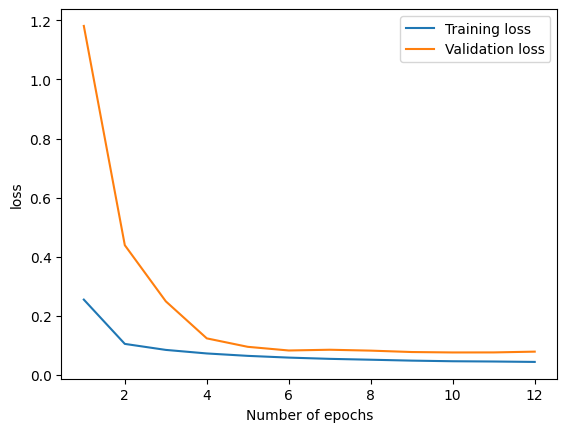

In [30]:
plt.plot(range(1,success_epoch), train_loss_list, label="Training loss") 
plt.plot(range(1,success_epoch), valid_loss_list, label="Validation loss") 
plt.xlabel("Number of epochs") 
plt.ylabel("loss") 
plt.legend()

ValueError: x and y must have same first dimension, but have shapes (13,) and (12,)

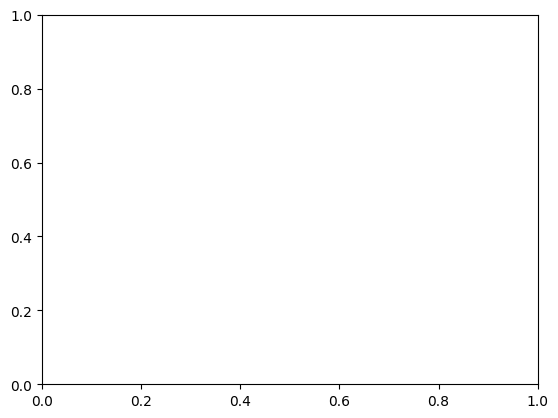

In [31]:
# plt.plot(range(1,success_epoch+1), train_loss_list, label="Training loss") 
# plt.plot(range(1,success_epoch+1), valid_loss_list, label="Validation loss") 
# plt.xlabel("Number of epochs") 
# plt.ylabel("loss") 
# plt.legend()

In [ ]:
folder = r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Testing'

test_folder = folder + '\Test'
test_gt_folder = folder + '\Test_gt'
test_results_folder = folder + '\Test_results'

test_files = os.listdir(test_folder)
test_gt_files = os.listdir(test_gt_folder)

In [ ]:
images_test = []
for file in test_files:
    images_test.append(test_folder + "\/" + file)

In [1]:
threshold = 0.5
model.eval()
with torch.no_grad():
    for image in images_test:
        filename = os.path.basename(image)
        #cropped_image = crop_image(np.array(Image.open(image)), 20, 40)
        #image = Image.fromarray(cropped_image)
        image = Image.open(image)
        orig_image = image
        image = image.resize((256, 256), resample=Image.NEAREST)
        #image = image.convert('L')
        image = transform(image)
        image = image.unsqueeze(0)

        image = image.to(device) 
        output = model(image)

        output = output.detach().cpu().numpy()[0]
        output = output * 10
        output = (output > threshold)
        print(output.shape)
        output = np.transpose(output, (1, 2, 0))
        
        plt.imshow(output)
        
        break
        
        # output_dict = {"mask": output}
        # savemat(test_results_folder + "\/" + filename.strip(".jpg") + ".mat", output_dict)

NameError: name 'model' is not defined

In [ ]:
plt.imshow(np.transpose(image.squeeze().to('cpu').numpy(), (1, 2, 0)))

In [ ]:
unique_values, counts = np.unique(output, return_counts=True)
for value, count in zip(unique_values, counts):
    print(str(value) +":    "+str(count))

In [ ]:
np.max(output)